In [42]:
# importing the libraries
import pandas as pd
import numpy as np
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD




from torchvision.datasets import CIFAR10
import torchvision
import torchvision.transforms as transforms
import torch
import pickle

In [43]:
cuda0 = torch.device('cuda:0')


In [44]:
batch_size = 128

In [45]:
dataset = CIFAR10(root='data', download=True)

Files already downloaded and verified


In [46]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [47]:
transform = transforms.Compose([
   transforms.RandomHorizontalFlip(),
   transforms.ColorJitter(0.1,0.1,0.1,0.1),
   transforms.RandomRotation(20),
   transforms.ToTensor(),
   transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=32)

Files already downloaded and verified
Files already downloaded and verified


In [48]:
torch.manual_seed(43)
val_size = 10000
from torch.utils.data import random_split
train_size = len(trainset) - val_size

trainset, valset = random_split(trainset, [train_size, val_size])
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=32)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=32)

In [49]:

len(trainset)


40000

<class 'torch.Tensor'>
images.shape: torch.Size([128, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


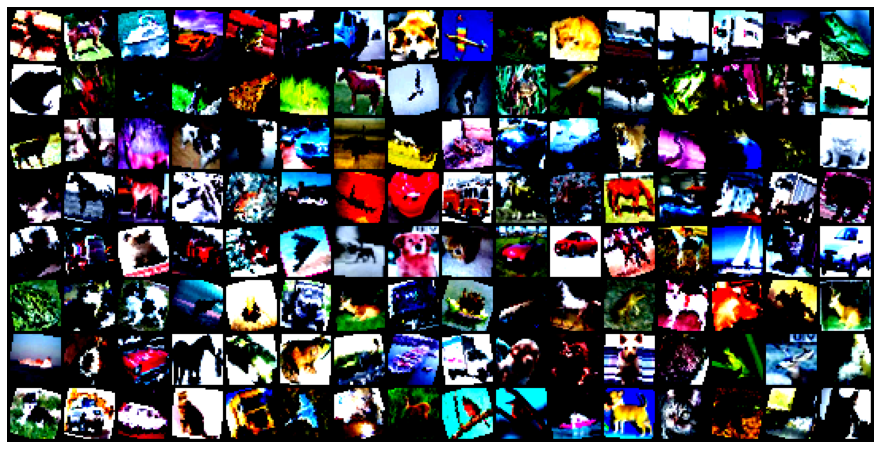

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


for images, _ in trainloader:
    print(type(images))
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(torchvision.utils.make_grid(images, nrow=16).permute((1, 2, 0)))
    break


In [51]:
class Net(Module):   
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer #1
            Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(16),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            # Defining another 2D convolution layer #2
            Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(32),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
             # Defining another 2D convolution layer #3
            Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.2),
             # Defining another 2D convolution layer #4
            Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(128),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.2),
           # Defining another 2D convolution layer #4
            Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(256),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2),
            Dropout(0.1),

        )

        self.linear_layers = Sequential(
            Linear(256 * 1 * 1, 64),
            ReLU(inplace=True),
            Dropout(0.1),
            Linear(64, 32),
            ReLU(inplace=True),
            Dropout(0.1),
            Linear(32, 10),

            
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [52]:
# defining the model
model = Net()
model = model.to(cuda0)
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
# defining the loss function
criterion = CrossEntropyLoss()

In [53]:
print(model)

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.2, inplace=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d

In [54]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min')

In [55]:
losses = []
losses_val = []
accuracy = []
accuracy_val = []
#min_loss = 0.2
#min_loss_val = 0.2
#max_acc = 0.7
#max_acc_val = 0.7
for epoch in range(150):  # loop over the dataset multiple times
    print('epoch: ',epoch)
    correct_v = 0.0
    loss_epoch_val = 0.0
    correct = 0.0
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
          running_loss += loss.item()
          _, predicted = torch.max(outputs.data, 1)
          correct += (predicted == labels).sum().item()
    with torch.no_grad():
      loss_epoch = running_loss / train_size
      losses.append(loss_epoch)
      acc_epoch = correct / train_size
      accuracy.append(acc_epoch)
      print('train loss: ', loss_epoch)
      print('train acc: ', acc_epoch)

    #Evaluate on validation set
    for i_batch, (x,y) in enumerate(valloader):
        with torch.no_grad():
            model.eval()
            x,y = x.to(cuda0), y.to(cuda0)
            outputs = model(x)
            loss = criterion(outputs, y)
            loss_epoch_val += loss

            _, predicted = torch.max(outputs.data, 1)
            correct_v += (predicted == y).sum().item()

    loss_epoch_val /= val_size
    acc_epoch_val = correct_v / val_size
    losses_val.append(loss_epoch_val)
    accuracy_val.append(acc_epoch_val)

    scheduler.step(loss_epoch_val)

    print('val loss: ', loss_epoch_val)
    print('val acc: ', acc_epoch_val)


print('Finished Training')

epoch:  0
train loss:  0.012872425350546836
train acc:  0.388075
val loss:  tensor(0.0109, device='cuda:0')
val acc:  0.4843
epoch:  1
train loss:  0.010552128759026527
train acc:  0.511725
val loss:  tensor(0.0097, device='cuda:0')
val acc:  0.5526
epoch:  2
train loss:  0.009790456549823284
train acc:  0.551625
val loss:  tensor(0.0090, device='cuda:0')
val acc:  0.5837
epoch:  3
train loss:  0.009229650491476058
train acc:  0.5779
val loss:  tensor(0.0088, device='cuda:0')
val acc:  0.5925
epoch:  4
train loss:  0.00884684579372406
train acc:  0.598475
val loss:  tensor(0.0083, device='cuda:0')
val acc:  0.6261
epoch:  5
train loss:  0.008477368542551994
train acc:  0.6192
val loss:  tensor(0.0080, device='cuda:0')
val acc:  0.6353
epoch:  6
train loss:  0.008200342552363873
train acc:  0.6295
val loss:  tensor(0.0077, device='cuda:0')
val acc:  0.647
epoch:  7
train loss:  0.007996723701059819
train acc:  0.641875
val loss:  tensor(0.0076, device='cuda:0')
val acc:  0.656
epoch:  8

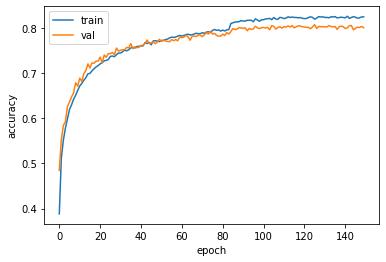

In [56]:
#plt.title('Train accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(list(range(150)),accuracy, label='train')
plt.plot(list(range(150)),accuracy_val, label='val')
plt.legend(loc="upper left")
# plt.savefig('transforms_p2.jpg')

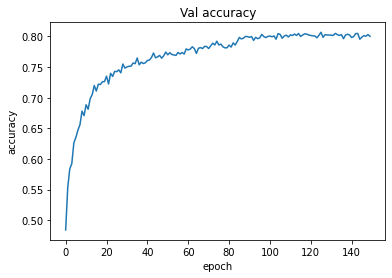

In [57]:
plt.title('Val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(accuracy_val)

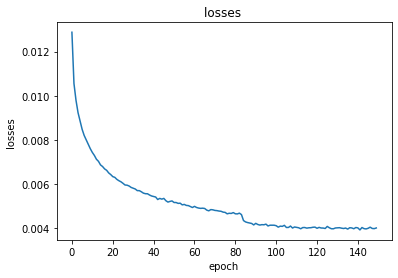

In [58]:
plt.title('losses ')
plt.xlabel('epoch')
plt.ylabel('losses ')
plt.plot(losses )

In [59]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in trainloader:
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 train images: 88 %


In [60]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [ ]:
correct = 0
total = 0
with torch.no_grad():
    model.eval()
    for data in testloader:
        inputs, labels = data
        inputs = inputs.to(cuda0)
        labels = labels.to(cuda0)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))